In [1]:
# Custom function to transform the date in 5 factors dataframe
def to_date(row):
    year = str(row)[:4]
    month = str(row)[4:6]
    day = str(row)[6:]

    return pd.to_datetime('-'.join([year, month, day]))

In [2]:
# Import dependencies
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read the Fama and French factors
factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')
factors['Date'] = factors.Date.apply(to_date)

In [4]:
# Get the historical data of Microsoft
returns = {}
tickers = ["FB", "AMZN", "AAPL", "NFLX", "GOOG"]
for t in tickers:
    df = yf.Ticker(t)
    df = df.history(period="max")

    # Calculate the return
    returns[t] = df['Close'].pct_change(1)
    
returns = pd.DataFrame(returns).dropna()
returns.reset_index(inplace=True)

In [5]:
# Merging the dataframes and remove row that contains Nan values
df = pd.merge(factors, returns[['Date', "FB", "AMZN", "AAPL", "NFLX", "GOOG"]], on='Date')
for t in tickers:
    df[t] = df[t] - df['RF']
    
df

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,FB,AMZN,AAPL,NFLX,GOOG
0,2012-05-21,1.69,0.56,-1.09,-0.29,-0.63,0.0,-0.109861,0.019920,0.058261,0.025443,0.022835
1,2012-05-22,0.00,-0.84,0.36,-0.11,-0.01,0.0,-0.089039,-0.012746,-0.007679,-0.056175,-0.021674
2,2012-05-23,0.26,0.50,-0.23,-0.03,-0.07,0.0,0.032258,0.009056,0.024400,0.062029,0.014414
3,2012-05-24,0.16,0.02,0.17,0.36,0.56,0.0,0.032187,-0.009389,-0.009184,-0.022806,-0.009517
4,2012-05-25,-0.16,0.25,-0.14,0.18,0.13,0.0,-0.033909,-0.010918,-0.005360,-0.000711,-0.020094
...,...,...,...,...,...,...,...,...,...,...,...,...
2455,2022-02-22,-1.18,-0.37,0.12,-0.06,0.12,0.0,-0.019790,-0.015753,-0.017812,-0.035549,-0.008163
2456,2022-02-23,-1.96,0.07,1.25,0.00,1.07,0.0,-0.017963,-0.035756,-0.025864,-0.026287,-0.014045
2457,2022-02-24,1.88,0.67,-3.85,-1.74,-1.75,0.0,0.046107,0.045095,0.016680,0.061422,0.039883
2458,2022-02-25,2.23,-0.12,1.20,0.35,-0.19,0.0,0.013873,0.016058,0.012965,0.001974,0.013914


In [6]:
df_2017 = df[df.Date.dt.year >= 2017].copy()
df_2017.set_index('Date', inplace=True)
df_2017 = df_2017.resample("1M").mean()

# Fama and Macbeth

- How to avoid data measurement errors when try to regress return on estimated betas with some error in them.

- How to prevent heterokesdasticity from affecting the significance of the results.
(Heteroskedasticity refers to situations where the variance of the residuals is unequal over a range of measured values. )
- Two Stages Regression

#### 1) First regress each of n asset returns against m proposed risk factors to determine each asset's beta exposures.

In [7]:
alphas = pd.DataFrame()
betas = pd.DataFrame()
for t in tickers:
    for i in range(len(df_2017)):
        X = df_2017[['Mkt-RF', 'SMB', 'HML','RMW', 'CMA']]
        y = df_2017[t]

        # Add constant term (alpha and error term)
        X = sm.add_constant(X)

        y = pd.DataFrame([y.iloc[i]], columns=['Return'])
        y.index = X.iloc[[i]].index
        
        lr = sm.OLS(pd.DataFrame(y, columns=['Return']), X.iloc[[i]])
        res = lr.fit()
        res.summary()

        alphas.loc[X.iloc[[i]].index[0], t] = res.params[0]
        betas.loc[X.iloc[[i]].index[0], t] = res.params[1]

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/l

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a fu

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a fu

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a fu

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a fu

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 1 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a fu

#### 2) Then regress all asset returns for each of T time periods against the previously estimated betas to determine the risk premium for each factor.

In [8]:
mean_ret = df_2017[tickers].mean(axis=1)

In [9]:
betas = sm.add_constant(betas)
lr = sm.OLS(mean_ret, betas)
res = lr.fit()
res.summary()

/Users/hindy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                    0.1395
Date:                Sat, 16 Apr 2022   Prob (F-statistic):              0.982
Time:                        22:12:52   Log-Likelihood:                 242.03
No. Observations:                  62   AIC:                            -472.1
Df Residuals:                      56   BIC:                            -459.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.001     -3.994      0.000      -0.004      -0.001
FB             0.6546      1.220      0.537      0.594      -1.789       3.098
AMZN          -0.2620      1.503     -0.174      0.862      -3.272       2.749
AAPL          -0.0493      1.178     -0.042      0.967      -2.409       2.310
NFLX          -0.0246      1.027     -0.024      0.981      -2.081       2.032
GOOG          -0.5647      1.372     -0.412      0.682      -3.313       2.183
==============================================================================
Omnibus:                        1.517   Durbin-Watson:                   0.795
Prob(Omnibus):                  0.468   Jarque-Bera (JB):                1.135
Skew:                           0.025   Prob(JB):                        0.567
Kurtosis:                       2.339   Cond. No.                     2.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
df_2017

,Mkt-RF,SMB,HML,RMW,CMA,RF,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,,,,,,,
2017-01-31,0.098500,-0.066500,-0.133500,-0.027500,-0.052500,0.002,0.004296,0.002743,0.000348,0.004541,-0.000355
2017-02-28,0.185789,-0.111579,-0.082105,0.031579,-0.092632,0.002,0.000111,-0.000583,0.004719,-0.001433,-0.000275
2017-03-31,0.008696,0.034783,-0.143043,0.021304,-0.043478,0.001,0.001054,0.001111,0.001099,0.000762,-0.000638
2017-04-30,0.057895,0.027895,-0.105789,0.095263,-0.075789,0.003,-0.000017,-0.000723,-0.002987,-0.001282,0.001701
2017-05-31,0.049545,-0.133182,-0.175455,0.045455,-0.080455,0.003,-0.002584,0.000353,0.000057,0.000236,-0.000098
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31,0.310000,-0.119524,-0.020952,0.080476,-0.058095,0.000,-0.002032,0.001364,0.002785,0.006039,0.005229
2021-11-30,-0.070000,-0.081429,-0.020000,0.363810,0.070476,0.000,0.000298,0.002025,0.004870,-0.003293,-0.001799
2021-12-31,0.145000,-0.024545,0.137273,0.200000,0.182273,0.000,0.001832,-0.002199,0.003422,-0.002759,0.000778


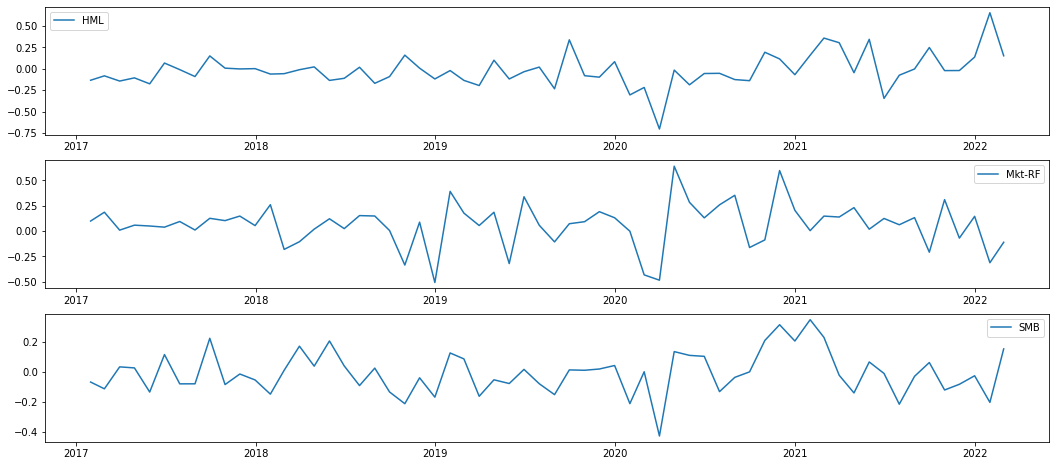

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 8))
ax = ax.flatten()
for i, f in enumerate(['HML', 'Mkt-RF', 'SMB']):
    ax[i].plot(df_2017.index, df_2017[f])
    ax[i].legend([f])
plt.show()